## Warehouse test

In [1]:
import os
import numpy as np
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [2]:
with open('./test_set/{}_{}agents.pth'.format('warehouse', 32), 'rb') as f:
    tests = pickle.load(f)

In [3]:
# negotiator를 구성하기 위한 union find 알고리즘
def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

def find_direction(sentence):
    # 모든 단어를 찾기 위한 정규 표현식 패턴
    words = re.findall(r'"([^"]*)"|\b\w+\b', sentence)
    directions = ["north", "west", "south", "east"]
    # 모든 단어를 뒤에서부터 확인
    for word in reversed(words):
        if word.lower() in directions:
            return word
    return 'none'

def determine_direction(x, y, x_finish, y_finish):

    try:
        dx = int(x_finish) - x
        dy = int(y_finish) - y
        
        if dx > 0 and dy > 0:
            return "northeast"
        elif dx > 0 and dy < 0:
            return "southeast"
        elif dx < 0 and dy > 0:
            return "northwest"
        elif dx < 0 and dy < 0:
            return "southwest"
        elif dx > 0 and dy == 0:
            return "east"
        elif dx < 0 and dy == 0:
            return "west"
        elif dx == 0 and dy > 0:
            return "north"
        elif dx == 0 and dy < 0:
            return "south"
        else:
            return "Same location"
    except ValueError:
        print("Invalid coordinates for direction determination")
        return "error"
    

# 방향 정의
directiondict = {
    'stay': 0, 'north': 1, 'south': 2, 'west': 3, 'east': 4
}

In [4]:
# 프롬프트
class gpt4pathfinding:
    def navigate(self, agent, direction, east, west, north, south, last_action, coordinates, agent_FOV):
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "당신은 방향 감각이 뛰어난 탐험가입니다. 당신은 목표물에 도달하기 위해서 어떤 경로를 탐색하야 할지 잘 압니다."},
            {"role": "user", "content":
                f"""
                당신의 지난 방문한 좌표들은 다음과 같습니다.
                오른쪽으로 갈수록 당신이 최근에 방문한 좌표입니다.
                {coordinates}

                1. 여기서 만약 3번 이상 반복되는 좌표가 있다면, 그 좌표를 지정하고 dead end라는 답을 내세요. 아니라면, no라는 답을 내세요.

                당신의 목표 지점은 당신의 {direction} 방향에 있습니다.

                당신은 가로로 긴 창고 환경에 있기 때문에, y축으로 이동이 가능할 때는 y축을 먼저 이용하는 것이 강력하게 추천됩니다.
                {east}
                {west}
                {south}
                {north}

                당신은 한 번에 한 번만 움직일 수 있습니다.
                당신의 행동에는 동쪽, 서쪽, 남쪽, 북쪽, 그리고 가만히 있기 5가지의 선택지가 있습니다.
                
                당신은 다음 어느 방향으로 움직일지 결정하세요.

                아래는 답변의 예시입니다. 토큰을 많이 사용하지 마세요.
                1. no
                2. north

                1. dead end at (2, 3)
                2. south
                """
            }],
        )
        return agent, response.choices[0].message.content
    
    def escape(self, deadenddirection, east, west, north, south):
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "당신은 방향 감각이 뛰어난 탐험가입니다. 당신은 목표물에 도달하기 위해서 어떤 경로를 탐색하야 할지 잘 압니다."},
            {"role": "user", "content":
                f"""
                당신은 dead end에서 똑같은 위치를 반복하고 있는 상태입니다.

                반복되는 좌표의 위치는 당신 기준 {deadenddirection}입니다.

                당신은 dead end로부터 최대한 멀리 떨어져야 합니다.

                당신의 행동에는 east, west, south, north의 선택지가 있습니다.

                {east}
                {west}
                {south}
                {north}

                1. 당신은 다음 어느 방향으로 움직일지 결정하세요.

                아래는 답변의 예시입니다. Answer with only one word.
                south
                """
            }],
        )
        return response.choices[0].message.content
    
    def give_way(self, east, west, north, south, direction):
        response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a veteran adventurer with a great sense of direction. You understand which direction you need to move to get from where you are to where you want to go."},
            {"role": "user", "content":
                f"""
                You MUST avoid collisions with prior path finder.
                You can only move east, west, south and north or stay.
                So, your answer will be {{east}}, {{west}}, {{south}}, {{north}}, or {{stay}}.
                You can only make one move at a time.
                {east}
                {west}
                {south}
                {north}
                To the {direction} of you is prior path finder.
                I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.

                1. Which direction do you move next?

                아래는 답변의 예시입니다. Answer with only one word.
                south
                """
            }],
        )
        return response.choices[0].message.content
    
pathfinder = gpt4pathfinding()

In [8]:
def run_one_example(example, max_steps):

  num_agents = len(example[1])
  map_width = len(example[0]) - 1

  env = Environment()
  env.load(np.array(example[0]), np.array(example[1]), np.array(example[2]))

  def parameter_navigate(i):

    observe = env.observe()

    a_obs = observe[0][i][1]
    x = observe[1][i][1]
    y = map_width-observe[1][i][0]
    x_finish = example[2][i][1]
    y_finish = map_width-example[2][i][0]
    direction = determine_direction(x, y, x_finish, y_finish)

    if a_obs[4][3] == 0:
      west = """To your west lies a path."""
    else:
      west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
      east = """To your east lies a path."""
    else:
      east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
      south = """To your south lies a path."""
    else:
      south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
      north = """To your north lies a path."""
    else:
      north = """Your north is blocked by a wall."""

    if len(action_list[i]) == 0:
      last_action = """"""
    elif action_list[i][-1] in ['West', 'West.']:
      last_action = f"""You came from east."""
    elif action_list[i][-1] in ['East', 'East.']:
      last_action = f"""You came from west."""
    elif action_list[i][-1] in ['South', 'South.']:
      last_action = f"""You came from north."""
    elif action_list[i][-1] in ['North', 'North.']:
      last_action = f"""You came from south."""
    elif action_list[i][-1] in ['Stay', 'Stay.']:
      last_action = f"""You paused once for another agent or you reached your goal."""
    else:
      last_action = """"""

    coordinates = f"""{coordinate_list[i]}"""

    agent_FOV = '\n'.join(' '.join(map(str, row)) for row in env.observe()[0][i][1][2:7, 2:7])

    return direction, east, west, north, south, last_action, coordinates, agent_FOV
  
  def parameter_give_way(i):

    observe = env.observe()

    a_obs = observe[0][i][1]
    x = observe[1][i][1]
    y = map_width-observe[1][i][0]
    x_finish = example[2][i][1]
    y_finish = map_width-example[2][i][0]

    if a_obs[4][3] == 0:
        west = """To your west lies a path."""
    else:
        west = """Your west is blocked by a wall."""

    if a_obs[4][5] == 0:
        east = """To your east lies a path."""
    else:
        east = """Your east is blocked by a wall."""

    if a_obs[5][4] == 0:
        south = """To your south lies a path."""
    else:
        south = """Your south is blocked by a wall."""

    if a_obs[3][4] == 0:
        north = """To your north lies a path."""
    else:
        north = """Your north is blocked by a wall."""

    # prior agent의 direction 구하기
    agent_map = env.observe()[0][i][0][2:7, 2:7]
    center = (2, 2)
    max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

    row_diff = center[0] - max_position[0]
    col_diff = center[1] - max_position[1]

    if row_diff > 0 and col_diff > 0:
        direction = "northwest"
    elif row_diff > 0 and col_diff == 0:
        direction = "north"
    elif row_diff > 0 and col_diff < 0:
        direction = "northeast"
    elif row_diff == 0 and col_diff > 0:
        direction = "west"
    elif row_diff == 0 and col_diff < 0:
        direction = "east"
    elif row_diff < 0 and col_diff > 0:
        direction = "southwest"
    elif row_diff < 0 and col_diff == 0:
        direction = "south"
    elif row_diff < 0 and col_diff < 0:
        direction = "southeast"
    else:
        direction = "center"

    return east, west, north, south, direction

  
  #에이전트들의 지난번 액션들과 좌표
  action_list = [[] for _ in range(num_agents)]
  coordinate_list = [[] for _ in range(num_agents)]
  step_list = [0 for _ in range(num_agents)]
  steps = 0

  # turn
  while steps < max_steps:

    for i in range(num_agents):
      if not np.array_equal(env.agents_pos[i], env.goals_pos[i]):
        step_list[i] += 1

    for i in range(num_agents):
      x_coordinate = env.observe()[1][i][1]
      y_coordinate = map_width-env.observe()[1][i][0]

      if len(coordinate_list[i]) >= 5:
        coordinate_list[i].pop(0)

      coordinate_list[i].append([x_coordinate, y_coordinate])

    step = [0 for i in range(num_agents)]

    #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
    FOV_agents = []
    for i in range(num_agents):
      if np.any(env.observe()[0][i][0][2:7, 2:7]):
        non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
        non_zero_elements = [element - 1 for element in non_zero_elements]
        non_zero_elements.append(i)
        FOV_agents.append(non_zero_elements)

    #알고리즘을 이용해 연결된 집합 찾기
    connected_sets = merge_sets(FOV_agents)

    #연결이 있는 모든 에이전트들
    deadlocked_agents = [item for sublist in connected_sets for item in sublist]

    parameters = []

    for i in range(num_agents):

      if np.array_equal(env.agents_pos[i], env.goals_pos[i]):
        step[i] = directiondict['stay']
        continue  # 다음 에이전트로 넘어감

      #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
      if i not in deadlocked_agents:

        direction, east, west, north, south, last_action, coordinates, agent_FOV = parameter_navigate(i)

        parameters.append([i, direction, east, west, north, south, last_action, coordinates, agent_FOV])

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_agents) as executor:
      # 각 프롬프트에 대해 비동기 작업 제출
      futures = [executor.submit(pathfinder.navigate, parameter[0], parameter[1], parameter[2], parameter[3], parameter[4], parameter[5], parameter[6], parameter[7], parameter[8]) for parameter in parameters]
      
      results = []

      # 각 작업의 결과 출력
      for future in concurrent.futures.as_completed(futures):
          result = future.result()
          results.append(result)

      print(results)

    for (i, result) in results: 
        lines = result.split('\n')

        # 첫 번째 줄과 두 번째 줄을 변수에 할당
        result1 = lines[0]
        result2 = lines[1]

        if "dead end" in result1:
          try:
            coords = result1.split(" at ")[1].strip("()").split(", ")
            x_finish = int(coords[0])
            y_finish = int(coords[1])
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            deadenddirection = determine_direction(x, y, x_finish, y_finish)
            escape = pathfinder.escape(deadenddirection, east, west, north, south)
            direction = escape
          except (IndexError, ValueError):
            print("Error parsing dead end coordinates")
            direction = 'stay'
        else:
          try:
            direction = result2.split(". ")[1]
          except IndexError:
            print("Error parsing direction")
            direction = 'stay'
        
        if direction not in directiondict:
          direction = 'stay'

        action_list[i].append(direction)

        step[i] = directiondict[direction]
      
    
    # 교착상태에 빠진 에이전트에 대해
    for connected_set in connected_sets:
      
      results = []

      parameters = []

      for i in connected_set: # 여기서 i는 agent의 번호들
      
      #각각의 에이전트에 대해 원래 계획된 경로를 계산

        direction, east, west, north, south, last_action, coordinates, agent_FOV = parameter_navigate(i)

        _, result = pathfinder.navigate(i, direction, east, west, north, south, last_action, coordinates, agent_FOV)

        lines = result.split('\n')

        # 첫 번째 줄과 두 번째 줄을 변수에 할당
        result1 = lines[0]
        result2 = lines[1]

        if "dead end" in result1:
          try:
            coords = result1.split(" at ")[1].strip("()").strip("[]").split(", ")
            x_finish = int(coords[0])
            y_finish = int(coords[1])
            deadenddirection = determine_direction(x, y, x_finish, y_finish)
            escape = pathfinder.escape(deadenddirection, east, west, north, south)
            direction = escape
          except (IndexError, ValueError):
            print("Error parsing dead end coordinates")
            direction = 'stay'
        else:
          try:
            direction = result2.split(". ")[1]
          except IndexError:
            print("Error parsing direction")
            direction = 'stay'
        
        if direction not in directiondict:
          direction = 'stay'

        results.append(direction)

      env_copy = copy.deepcopy(env)
      planned_step = [0 for _ in range(num_agents)]
      for idx, agent_idx in enumerate(connected_set):
        planned_step[agent_idx] = directiondict[results[idx]]
      if -0.5 in env_copy.step(planned_step)[1]:
        collision = True
      else:
        collision = False

      if not collision:
        for idx, agent_idx in enumerate(connected_set):
          action_list[agent_idx].append(results[idx])
          step[agent_idx] = directiondict[results[idx]]
      # 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
      # 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
      else:
      # 먼저 prior agent는 원래대로 이동하게 함
        prior_agent_number = max(connected_set)
        prior_agent_idx = connected_set.index(prior_agent_number)
        action_list[prior_agent_number].append(results[prior_agent_idx])
        step[prior_agent_number] = directiondict[results[prior_agent_idx]]
        for i in connected_set:
          if i != prior_agent_number:
              
              east, west, north, south, direction = parameter_give_way(i)

              result = pathfinder.give_way(east, west, north, south, direction)

              direction = result

              if direction not in directiondict:
                direction = 'stay'

              action_list[i] = []
      
              step[i] = directiondict[direction]

    observation, rewards, done, info = env.step(step)

    env.render()

    if done:
      break
    steps += 1

  return step_list

In [9]:
def simulate_all_tests(tests, max_steps):
    all_step_lists = []
    for example in tests:
        step_list = run_one_example(example, max_steps)
        all_step_lists.append(step_list)
        print(step_list)
    return all_step_lists

[(17, '1. no\n2. east'), (25, '1. no\n2. north'), (3, '1. no\n2. north'), (4, '1. no\n2. north'), (30, '1. no\n2. north'), (12, '1. no\n2. north'), (16, '1. no\n2. west'), (31, '1. no\n2. north'), (20, '1. no\n2. north'), (6, '1. no\n2. west'), (26, '1. no\n2. west'), (13, '1. no\n2. west'), (11, '1. no\n2. south'), (8, '1. no\n2. west'), (21, '1. no\n2. north'), (14, '1. no\n2. north'), (23, '1. no\n2. east'), (28, '1. no\n2. east'), (24, '1. no\n2. north'), (22, '1. no\n2. west'), (5, '1. no\n2. east'), (18, '1. no\n2. west'), (9, '1. no\n2. south'), (10, '1. no\n2. north'), (15, '1. no\n2. north'), (19, '1. no\n2. west'), (0, '1. no\n2. north'), (1, '1. no\n2. east')]


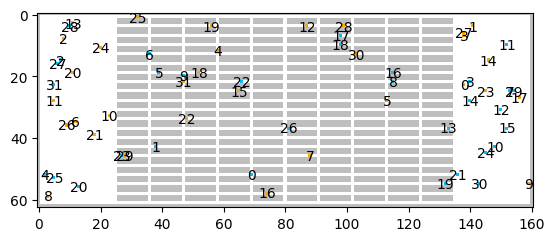

[(3, '1. no\n2. north'), (11, '1. no\n2. south'), (13, '1. no\n2. west'), (15, '1. no\n2. north'), (5, '1. no\n2. east'), (25, '1. no\n2. north'), (0, '1. no\n2. north'), (1, '1. no\n2. east'), (9, '1. no\n2. south'), (17, '1. no\n2. east'), (24, '1. no\n2. north'), (30, '1. no\n2. north'), (16, '1. no\n2. west'), (6, '1. no\n2. south'), (21, '1. no\n2. north'), (26, '1. no\n2. west'), (18, '1. no\n2. west'), (31, '1. no\n2. north'), (14, '1. no\n2. north'), (22, '1. no\n2. west'), (19, '1. no\n2. west'), (20, '1. no\n2. north'), (10, '1. no\n2. north'), (4, '1. no\n2. north'), (28, '1. no\n2. east'), (8, '1. no\n2. west'), (23, '1. no\n2. east'), (12, '1. no\n2. north')]


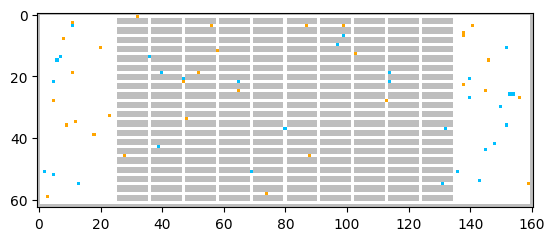

[(1, '1. no\n2. east'), (8, '1. no\n2. west'), (11, '1. no\n2. south'), (3, '1. no\n2. north'), (25, '1. no\n2. north'), (24, '1. no\n2. north'), (9, '1. no\n2. south'), (20, '1. no\n2. north'), (19, '1. no\n2. west'), (17, '1. no\n2. east'), (28, '1. no\n2. east'), (30, '1. no\n2. north'), (18, '1. no\n2. west'), (21, '1. no\n2. north'), (16, '1. no\n2. west'), (5, '1. no\n2. east'), (0, '1. no\n2. north'), (26, '1. no\n2. north'), (23, '1. no\n2. east'), (14, '1. no\n2. north'), (10, '1. no\n2. north'), (12, '1. no\n2. north'), (6, '1. no\n2. south'), (13, '1. no\n2. west'), (15, '1. no\n2. north'), (22, '1. no\n2. west'), (31, '1. no\n2. east'), (4, '1. no\n2. north')]


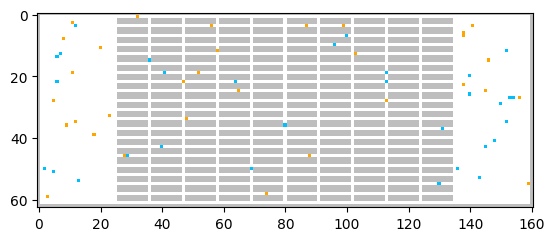

[(5, '1. no\n2. east'), (15, '1. no\n2. north'), (11, '1. no\n2. south'), (21, '1. no\n2. north'), (9, '1. no\n2. south'), (12, '1. no\n2. north'), (13, '1. no\n2. west'), (20, '1. no\n2. north'), (1, '1. no\n2. east'), (25, '1. no\n2. north'), (8, '1. no\n2. south'), (23, '1. no\n2. east'), (3, '1. no\n2. north'), (18, '1. no\n2. west'), (17, '1. no\n2. east'), (14, '1. no\n2. north'), (6, '1. no\n2. south'), (24, '1. no\n2. north'), (22, '1. no\n2. west'), (30, '1. no\n2. north'), (4, '1. no\n2. north'), (10, '1. no\n2. north'), (26, '1. no\n2. north'), (0, '1. no\n2. north'), (16, '1. no\n2. south'), (28, '1. no\n2. east'), (31, '1. no\n2. east'), (19, '1. no\n2. west')]


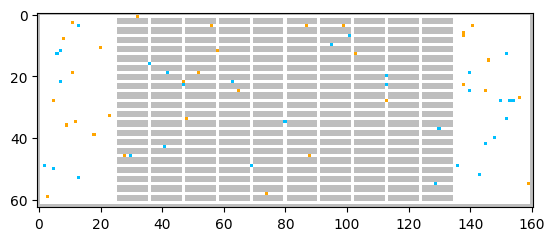

[(9, '1. no\n2. south'), (1, '1. no\n2. east'), (6, '1. no\n2. south'), (25, '1. no\n2. north'), (3, '1. no\n2. north'), (4, '1. no\n2. north'), (15, '1. no\n2. north'), (19, '1. no\n2. west'), (24, '1. no\n2. north'), (10, '1. no\n2. north'), (8, '1. no\n2. south'), (28, '1. no\n2. east'), (20, '1. no\n2. north'), (5, '1. no\n2. east'), (30, '1. no\n2. north'), (23, '1. no\n2. east'), (0, '1. no\n2. north'), (12, '1. no\n2. north'), (21, '1. no\n2. north'), (22, '1. no\n2. west'), (11, '1. no\n2. south'), (17, '1. no\n2. east'), (26, '1. no\n2. south'), (14, '1. no\n2. north'), (16, '1. no\n2. south'), (31, '1. no\n2. east'), (18, '1. no\n2. west'), (13, '1. no\n2. west')]


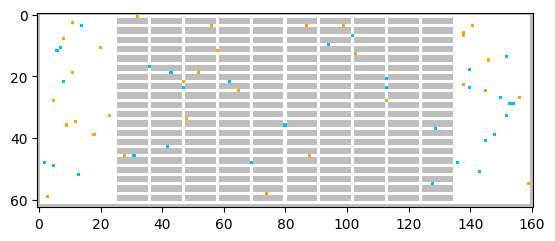

[(11, '1. no\n2. south'), (12, '1. no\n2. north'), (5, '1. no\n2. east'), (1, '1. no\n2. east'), (0, '1. no\n2. north'), (3, '1. no\n2. north'), (17, '1. no\n2. south'), (18, '1. no\n2. west'), (8, '1. no\n2. south'), (19, '1. no\n2. west'), (16, '1. no\n2. south'), (24, '1. no\n2. north'), (28, '1. no\n2. east'), (30, '1. no\n2. north'), (26, '1. no\n2. south'), (25, '1. no\n2. north'), (14, '1. no\n2. north'), (21, '1. no\n2. north'), (20, '1. no\n2. north'), (10, '1. no\n2. north'), (31, '1. no\n2. east'), (13, '1. no\n2. west'), (15, '1. no\n2. north'), (9, '1. no\n2. south'), (4, '1. no\n2. north'), (22, '1. no\n2. west'), (6, '1. no\n2. south'), (23, '1. no\n2. east')]


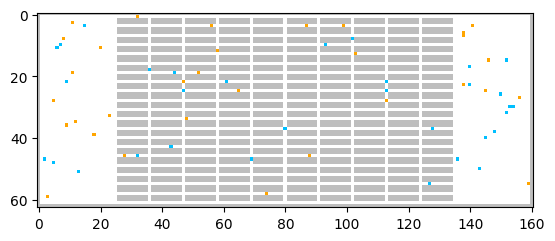

[(3, '1. no\n2. north'), (9, '1. no\n2. south'), (4, '1. no\n2. north'), (0, '1. no\n2. north'), (1, '1. no\n2. east'), (20, '1. no\n2. north'), (31, '1. no\n2. east'), (28, '1. no\n2. east'), (10, '1. no\n2. north'), (11, '1. no\n2. south'), (19, '1. no\n2. west'), (25, '1. no\n2. north'), (24, '1. no\n2. north'), (17, '1. no\n2. south'), (12, '1. no\n2. north'), (13, '1. no\n2. west'), (18, '1. no\n2. west'), (23, '1. no\n2. east'), (16, '1. no\n2. south'), (8, '1. no\n2. south'), (22, '1. no\n2. west'), (21, '1. no\n2. north'), (14, '1. no\n2. north'), (30, '1. no\n2. north'), (5, '1. no\n2. east'), (6, '1. no\n2. south'), (26, '1. dead end at (80, 25)\n2. north')]


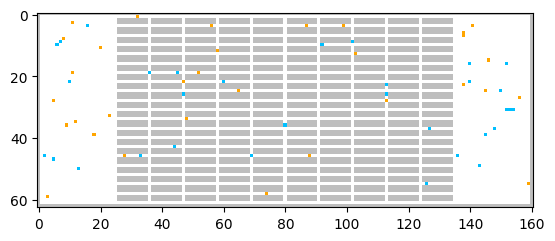

[(12, '1. no\n2. north'), (5, '1. no\n2. east'), (19, '1. no\n2. west'), (30, '1. no\n2. north'), (22, '1. no\n2. west'), (17, '1. no\n2. south'), (18, '1. no\n2. west'), (31, '1. no\n2. east'), (0, '1. no\n2. north'), (25, '1. no\n2. north'), (6, '1. no\n2. south'), (28, '1. no\n2. east'), (23, '1. no\n2. east'), (8, '1. no\n2. south'), (4, '1. no\n2. north'), (1, '1. no\n2. east'), (10, '1. no\n2. north'), (3, '1. no\n2. north'), (14, '1. no\n2. north'), (9, '1. no\n2. south'), (13, '1. no\n2. west'), (21, '1. no\n2. north'), (11, '1. no\n2. south'), (24, '1. no\n2. north'), (20, '1. no\n2. north'), (16, '1. no\n2. south'), (26, '1. dead end at (80, 26)\n2. north')]


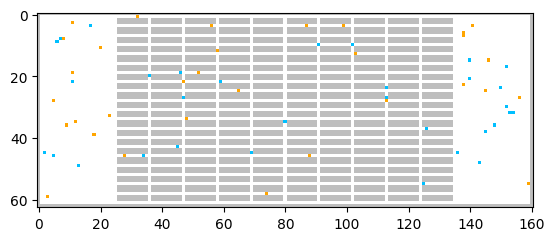

[(9, '1. no\n2. south'), (6, '1. no\n2. south'), (5, '1. no\n2. east'), (0, '1. no\n2. north'), (10, '1. no\n2. north'), (17, '1. no\n2. south'), (1, '1. no\n2. east'), (8, '1. no\n2. south'), (12, '1. no\n2. north'), (11, '1. no\n2. south'), (13, '1. no\n2. west'), (30, '1. no\n2. north'), (20, '1. no\n2. north'), (25, '1. no\n2. north'), (24, '1. no\n2. north'), (3, '1. no\n2. north'), (14, '1. no\n2. north'), (4, '1. no\n2. north'), (18, '1. no\n2. south'), (21, '1. no\n2. north'), (19, '답변:\n\n1. no\n2. west'), (31, '1. no\n2. east'), (22, '1. no\n2. west'), (16, '1. no\n2. south'), (23, '1. no\n2. east'), (26, '1. dead end at (80, 27)\n2. south'), (28, '1. no\n2. east')]
Error parsing direction


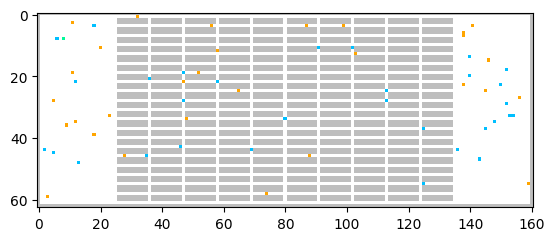

[(3, '1. no\n2. north'), (0, '1. no\n2. north'), (18, '1. no\n2. south'), (8, '1. no\n2. south'), (21, '1. no\n2. north'), (4, '1. no\n2. north'), (22, '1. no\n2. south'), (24, '1. no\n2. north'), (10, '1. no\n2. north'), (11, '1. no\n2. south'), (13, '1. no\n2. west'), (20, '1. no\n2. north'), (26, '1. no\n2. south'), (5, '1. no\n2. south'), (15, '1. no\n2. north'), (12, '1. no \n2. north'), (30, '1. no\n2. north'), (25, '1. no\n2. north'), (19, '1. no\n2. west'), (14, '1. no\n2. north'), (31, '1. no\n2. east'), (16, '1. no\n2. south'), (1, '1. no\n2. east'), (17, '1. no\n2. south'), (9, '1. no\n2. south'), (6, '1. no\n2. south'), (23, '1. no\n2. east'), (28, '1. no\n2. east')]


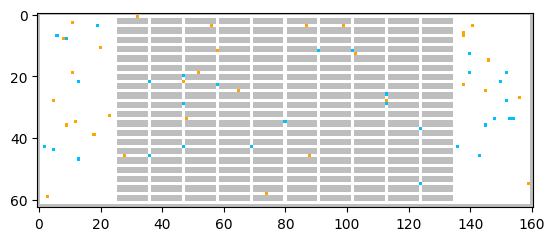

[(11, '1. no\n2. south'), (9, '1. no\n2. south'), (23, '1. no\n2. north'), (10, '1. no\n2. north'), (20, '1. no\n2. north'), (4, '1. no\n2. north'), (22, '1. no\n2. south'), (14, '1. no\n2. north'), (19, '1. no\n2. north'), (18, '1. no\n2. south'), (5, '1. no\n2. south'), (12, '1. no\n2. north'), (28, '1. no\n2. east'), (2, '1. no\n2. west'), (13, '1. no\n2. north'), (3, '1. no\n2. north'), (17, '1. no\n2. south'), (26, '1. no\n2. south'), (21, '1. no\n2. north'), (31, '1. no\n2. east'), (30, '1. no\n2. north'), (6, '1. no \n2. south'), (0, '1. no\n2. north'), (8, '1. no\n2. south'), (24, '1. no\n2. north'), (27, '1. no\n2. north'), (25, '1. no\n2. north'), (1, '1. no\n2. north'), (15, '1. no\n2. north'), (16, '1. no\n2. south')]


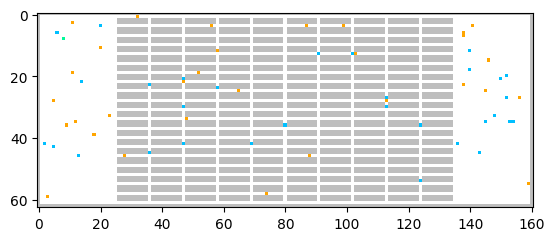

[(4, '1. no\n2. north'), (0, '1. no\n2. north'), (10, '1. no\n2. west'), (15, '1. no\n2. north'), (14, '1. no\n2. north'), (3, '1. no\n2. north'), (8, '1. no\n2. south'), (20, '1. no\n2. north'), (1, '1. no\n2. north'), (13, '1. no\n2. north'), (23, '1. no\n2. north'), (26, '1. no\n2. north'), (16, '1. no\n2. south'), (6, '1. no\n2. south'), (9, '1. no\n2. south'), (25, '1. no \n2. north'), (31, '1. no\n2. east'), (24, '1. no\n2. north'), (28, '1. no\n2. east'), (30, '1. no\n2. north'), (19, '1. no\n2. north'), (22, '1. no\n2. south'), (21, '1. no\n2. north'), (5, '1. no\n2. south'), (17, '1. no\n2. south'), (18, '1. no\n2. south')]


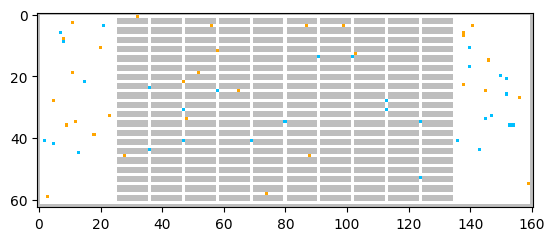

[(21, '1. no\n2. north'), (9, '1. no\n2. south'), (3, '1. no\n2. north'), (13, '1. no\n2. north'), (8, '1. no\n2. south'), (22, '1. no\n2. south'), (16, '1. no\n2. south'), (25, '1. no\n2. north'), (1, '1. no\n2. north'), (4, '1. no\n2. north'), (14, '1. no\n2. north'), (20, '1. no\n2. north'), (15, '1. no\n2. north'), (18, '1. no\n2. south'), (6, '1. no\n2. south'), (19, '1. no\n2. north'), (28, '1. no\n2. east'), (0, '1. no\n2. north'), (17, '1. no\n2. south'), (23, '1. no\n2. north'), (2, '1. dead end at (8, 54)\n2. north'), (27, '1. no\n2. east'), (26, '1. dead end at (80, 27)\n2. south'), (30, '1. no\n2. north'), (31, '1. no\n2. east'), (5, '위 주어진 좌표들을 보면, 좌표가 반복되는 경우는 존재하지 않습니다. 따라서 첫 번째 질문에 대한 답은 "no"입니다.\n\n제목에 명시된 바와 같이 목표물은 southeast 방향에 있습니다. 아래 주어진 조건에 따르면, 가로로 긴 창고 환경에 있기 때문에, y축으로 이동이 가능할 때에는 y축을 먼저 이용하는 것이 좋습니다. 하지만 현재 위치한 좌표를 보면 y축의 값이 계속 감소하는 경향을 보이고 있으며, 이는 반대로 x축의 값을 우선으로 움직여야 한다는 것을 의미합니다. 따라서 동쪽으로 이동하는 것이 좋겠습니다.\n\n따라서 답변은 다음과 같습니다.\n1. no\n2. east')]
Error parsing

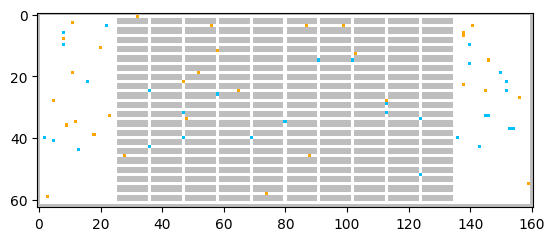

[(0, '1. no\n2. north'), (20, '1. no\n2. north'), (15, '1. no\n2. west'), (6, '1. no\n2. south'), (16, '1. no\n2. south'), (30, '1. no\n2. north'), (21, '1. no\n2. north'), (3, '1. no\n2. north'), (12, '1. no\n2. north'), (9, '1. no\n2. south'), (1, '1. no\n2. north'), (22, '1. no\n2. south'), (11, '1. no\n2. south'), (27, '1. no\n2. east'), (8, '1. no\n2. south'), (13, '1. no\n2. north'), (5, '1. no\n2. south'), (31, '1. no\n2. east'), (28, '1. no\n2. east'), (14, '1. no\n2. north'), (17, '1. no\n2. south'), (2, '1. dead end at (8, 54)\n2. north'), (23, '                1. no\n                2. north'), (19, '1. no\n2. north'), (25, '1. no\n2. north'), (4, '1. no\n2. north'), (26, '1. dead end at (80, 27)\n2. south'), (18, '1. no\n2. south')]


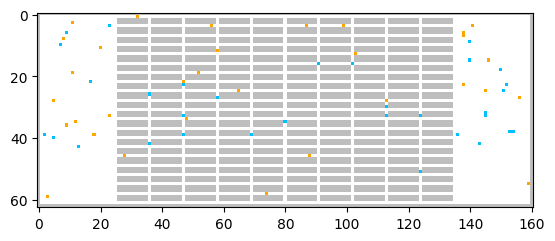

[(0, '1. no\n2. north'), (3, '1. no\n2. north'), (16, '1. no\n2. south'), (17, '1. no\n2. south'), (27, '1. no\n2. east'), (14, '1. no\n2. east'), (4, '1. no\n2. north'), (31, '1. no\n2. east'), (28, '1. no\n2. east'), (2, '1. no\n2. north'), (8, '1. no\n2. south'), (13, '1. no\n2. north'), (9, '1. no\n2. south'), (1, '1. no\n2. north'), (5, '1. no\n2. south'), (12, '1. no\n2. north'), (30, '1. no\n2. north'), (18, '1. no\n2. south'), (20, '1. no\n2. north'), (25, '1. no\n2. north'), (19, '1. no\n2. north'), (23, '1. no\n2. north'), (6, '1. no\n2. south'), (22, '1. no\n2. south'), (26, '1. dead end at (80, 27)\n2. south'), (21, '1. no\n2. west')]


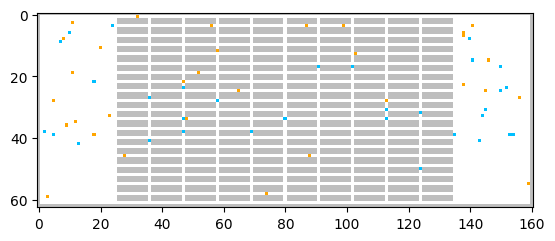

[(2, '1. no\n2. north'), (0, '1. no\n2. north'), (17, '1. no\n2. south'), (23, '1. no\n2. north'), (12, '1. no\n2. north'), (8, '1. no\n2. south'), (4, '1. no\n2. north'), (9, '1. no\n2. south'), (31, '1. no\n2. east'), (3, '1. no\n2. north'), (20, '1. no\n2. north'), (19, '1. no\n2. north'), (16, '1. no\n2. south'), (30, '1. no\n2. north'), (22, '1. no\n2. south'), (25, '1. no\n2. north'), (14, '1. no\n2. east'), (18, '1. no\n2. south'), (13, '1. no\n2. north'), (28, '1. no\n2. east'), (27, '1. no\n2. east'), (21, '1. no\n2. north'), (1, '1. no\n2. north'), (6, '1. no\n2. south'), (26, '1. dead end at (80, 27)\n2. south'), (5, '1. no\n2. south')]


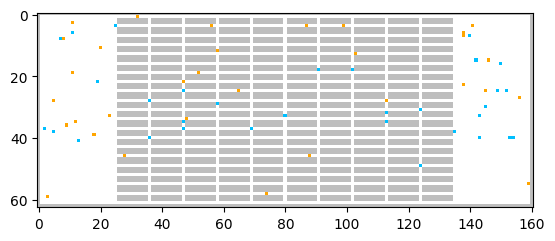

[(3, '1. no\n2. west'), (14, '1. no\n2. east'), (4, '1. no\n2. north'), (12, '1. no\n2. north'), (0, '1. no\n2. north'), (2, '1. no\n2. east'), (6, '1. no\n2. south'), (11, '1. no\n2. south'), (21, '1. no\n2. south'), (15, '1. no\n2. west'), (8, '1. no\n2. south'), (16, '1. no\n2. south'), (20, '1. no\n2. north'), (28, '1. no\n2. east'), (23, '1. no\n2. north'), (17, '1. no\n2. south'), (18, '1. no\n2. south'), (24, '1. no\n2. north'), (10, '1. no\n2. west'), (30, '1. no\n2. north'), (19, '1. no\n2. north'), (13, '1. no\n2. north'), (27, '1. no\n2. east'), (22, '1. no\n2. south'), (25, '1. no\n2. north'), (5, '1. dead end at (47, 40)\n2. south'), (31, '1. no\n2. east'), (26, '1. dead end at (80, 27)\n2. south')]


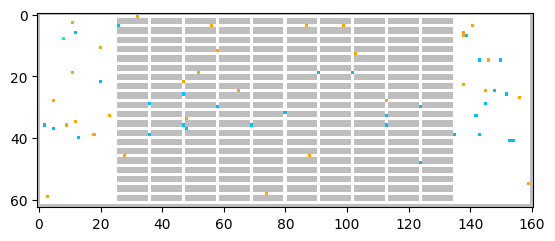

[(3, '1. no\n2. west'), (4, '1. no\n2. north'), (6, '1. no\n2. south'), (10, '1. no\n2. west'), (14, '1. no\n2. east'), (25, '1. no\n2. east'), (24, '1. no\n2. north'), (8, '1. no\n2. south'), (12, '1. no\n2. north'), (19, '1. no\n2. north'), (13, '1. no\n2. north'), (11, '1. no\n2. south'), (31, '1. no\n2. east'), (15, '1. no\n2. west'), (20, '1. no\n2. north'), (23, '1. no\n2. north'), (22, '1. no\n2. south'), (16, '1. no\n2. south'), (18, '1. no\n2. west'), (27, '1. no\n2. east'), (21, '1. no\n2. south'), (0, '1. no\n2. north'), (28, '1. no\n2. east'), (5, '1. no\n2. south'), (30, '1. no\n2. north'), (17, '1. no\n2. south'), (26, '1. dead end at (80, 27)\n2. south')]


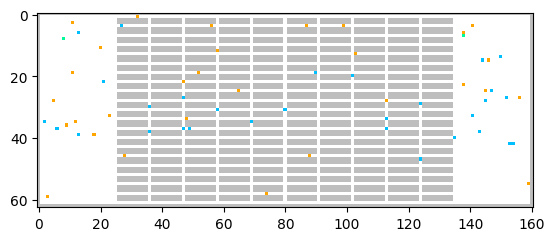

[(4, '1. no\n2. north'), (18, '1. no\n2. west'), (28, '1. no\n2. east'), (14, '1. no\n2. east'), (8, '1. no\n2. south'), (5, '1. no\n2. south'), (24, '1. no\n2. north'), (11, '1. no\n2. south'), (16, '1. no\n2. south'), (20, '1. no\n2. north'), (15, '1. no\n2. west'), (27, '1. no\n2. east'), (19, '1. no\n2. north'), (22, '1. no\n2. south'), (10, '1. no\n2. west'), (0, '1. no\n2. north'), (21, '1. no\n2. north'), (13, '1. no\n2. north'), (23, '1. no\n2. north'), (6, '1. no\n2. south'), (30, '1. no\n2. north'), (12, '1. no\n2. north'), (25, '1. no\n2. north'), (31, '1. no\n2. east'), (17, '1. no\n2. south'), (26, '1. no\n2. south')]


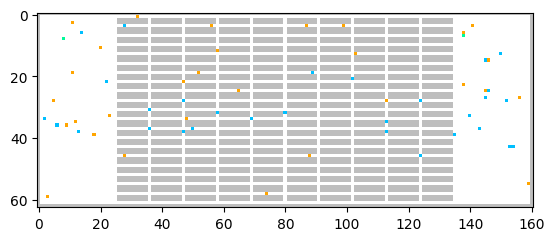

[(4, '1. no\n2. north'), (9, '1. no\n2. south'), (5, '1. no\n2. east'), (22, '1. no\n2. south'), (13, '1. no\n2. north'), (17, '1. no\n2. south'), (18, '1. no\n2. west'), (1, '1. no\n2. east'), (27, '1. no\n2. east'), (14, '1. no\n2. east'), (28, '1. no\n2. east'), (0, '1. no\n2. north'), (12, '1. no\n2. north'), (26, '1. no\n2. south'), (20, '1. no\n2. north'), (6, '1. no\n2. south'), (21, '1. dead end at (135, 23)\n2. north'), (30, '1. no\n2. north'), (10, '1. no\n2. west'), (23, '1. no\n2. north'), (25, '1. no\n2. north'), (31, '1. no\n2. east'), (16, '1. no\n2. south'), (11, '1. no\n2. west'), (8, '답변:\n1. no\n2. south'), (19, '1. no\n2. north')]


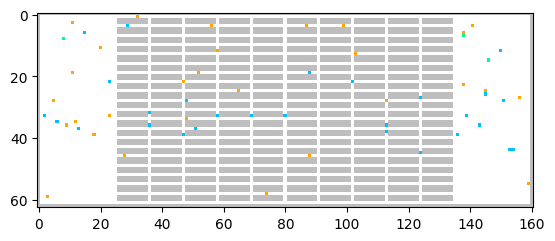

[(20, '1. no\n2. north'), (25, '1. no\n2. east'), (5, '1. no\n2. east'), (11, '1. no\n2. west'), (1, '1. no\n2. east'), (10, '1. no\n2. west'), (17, '1. no\n2. south'), (9, '1. no\n2. south'), (12, '1. no\n2. north'), (0, '1. no\n2. north'), (18, '1. no\n2. west'), (13, '1. no\n2. north'), (4, '1. no\n2. north'), (6, '1. no\n2. south'), (28, '1. no\n2. east'), (30, '1. no\n2. north'), (22, '1. no\n2. south'), (27, '1. no\n2. east'), (19, '1. no\n2. north'), (31, '1. no\n2. east'), (23, '1. no\n2. north'), (26, '1. dead end at [80, 30]\n2. south'), (21, '1. dead end at (135, 23)\n2. west')]
Error parsing dead end coordinates


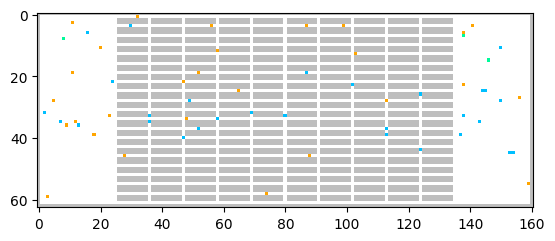

[(4, '1. no\n2. north'), (27, '1. no\n2. east'), (18, '1. no\n2. west'), (9, '1. no\n2. south'), (0, '1. no\n2. north'), (20, '1. no\n2. north'), (28, '1. no\n2. east'), (17, '1. no\n2. south'), (5, '1. no\n2. east'), (31, '1. no\n2. east'), (13, '1. no\n2. north'), (11, '1. no\n2. west'), (25, '1. no\n2. north'), (30, '1. no\n2. north'), (12, '1. no\n2. north'), (19, '1. no\n2. north'), (21, '1. dead end at [135, 23]\n2. west'), (1, '1. no\n2. east'), (22, '1. no\n2. west'), (10, '1. no\n2. west'), (26, '1. dead end at (80, 30)\n2. south')]
Error parsing dead end coordinates


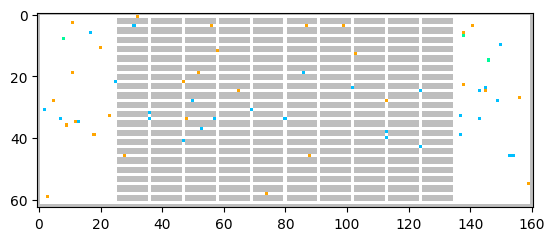

[(4, '1. no\n2. north'), (0, '1. no\n2. north'), (11, '1. no\n2. west'), (1, '1. no\n2. east'), (20, '1. no\n2. north'), (27, '1. no\n2. east'), (30, '1. no\n2. north'), (18, '1. no\n2. west'), (19, '1. no\n2. north'), (25, '1. no\n2. north'), (9, '1. no\n2. south'), (22, '1. no\n2. west'), (13, '1. no\n2. north'), (10, '1. no\n2. west'), (28, '1. no\n2. east'), (31, '1. no\n2. east'), (21, '1. dead end at (137, 23)\n2. west'), (5, '1. no\n2. east'), (17, '1. no\n2. south'), (12, '1. no\n2. north'), (26, '1. [80, 29] 좌표가 2번 반복되었지만, 3번 이상 반복된 좌표는 없으므로 no\n2. 목표 지점이 남서쪽에 있고, y축 이동이 우선적으로 추천되므로 south.')]


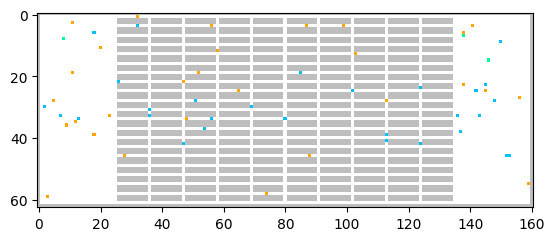

[(9, '1. no\n2. south'), (11, '1. no\n2. west'), (20, '1. no\n2. north'), (19, '1. no\n2. north'), (0, '1. no\n2. north'), (5, '1. no\n2. east'), (17, '1. no\n2. south'), (12, '1. no\n2. north'), (27, '1. no\n2. east'), (1, '1. no\n2. east'), (30, '1. No\n2. North'), (15, '1. no\n2. west'), (18, '1. no\n2. west'), (13, '1. no\n2. north'), (22, '1. no\n2. west'), (24, '1. no\n2. north'), (31, '1. no\n2. east'), (25, '1. no\n2. north'), (21, '1. dead end at (137, 23)\n2. south'), (4, '1. no\n2. north'), (28, '1. no\n2. east'), (26, '1. no\n2. south'), (10, '1. no\n2. west')]


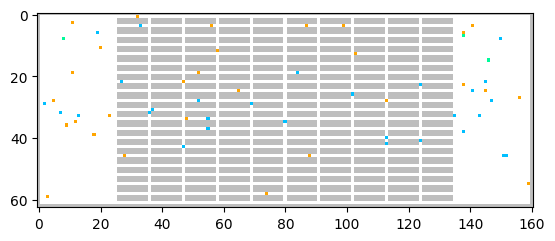

[(11, '1. no\n2. west'), (17, '1. no\n2. south'), (13, '1. no\n2. north'), (19, '1. no\n2. north'), (20, '1. no\n2. north'), (15, '1. no\n2. west'), (4, '1. no\n2. north'), (25, '1. no\n2. north'), (22, '1. no\n2. west'), (28, '1. no\n2. east'), (18, '1. no\n2. west'), (24, '1. no\n2. north'), (27, '1. no\n2. east'), (1, '1. no\n2. east'), (12, '1. no\n2. north'), (9, '1. no\n2. south'), (5, '1. no\n2. east'), (31, '1. no\n2. east'), (21, '1. dead end at (137, 23)\n2. south'), (10, '1. no\n2. south'), (0, '1. no\n2. north'), (26, '1. dead end at (80, 29)\n2. south'), (30, '1. yes, dead end at (143, 29)\n2. north')]


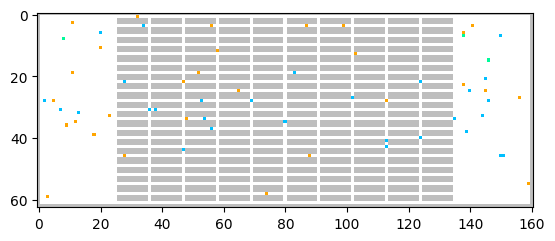

[(5, '1. no\n2. east'), (10, '1. no\n2. north'), (18, '1. no\n2. west'), (4, '1. no\n2. north'), (22, '1. no\n2. west'), (9, '1. no\n2. south'), (15, '1. no\n2. west'), (12, '1. no\n2. north'), (21, '1. No\n2. South'), (20, '1. no\n2. north'), (28, '1. no\n2. east'), (17, '1. no\n2. north'), (25, '1. no\n2. north'), (0, '1. no\n2. north'), (1, '1. no\n2. east'), (11, '1. no\n2. west'), (13, '1. no\n2. north'), (26, '1. dead end at (80, 28)\n2. south'), (27, '1. no\n2. east'), (19, '1. no\n2. north'), (24, '1. no\n2. north'), (30, '1. dead end at (143, 29)\n2. north'), (31, '1. no\n2. east')]


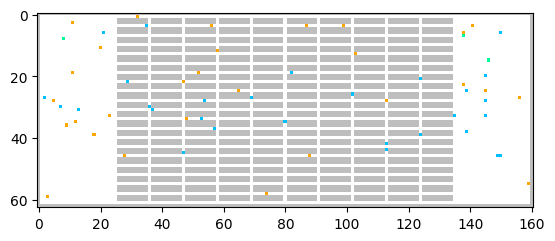

[(12, '1. no\n2. north'), (4, '1. no\n2. north'), (0, '1. no\n2. north'), (24, '1. no\n2. north'), (27, '1. no\n2. east'), (1, '1. no\n2. east'), (11, '1. no\n2. west'), (19, '1. no\n2. north'), (20, '1. no\n2. north'), (22, '1. no\n2. west'), (10, '1. dead end at (135, 29)\n2. north'), (31, '1. no\n2. east'), (13, '1. no\n2. north'), (21, '1. no\n2. south'), (17, '1. no\n2. south'), (25, '1. no\n2. north'), (18, '1. no\n2. west'), (9, '1. no\n2. south'), (30, '1. dead end at (143, 29)\n2. north'), (15, '1. no\n2. west'), (28, '1. no\n2. east'), (5, '1. no\n2. east'), (26, '1. dead end at (80, 27)\n2. south')]


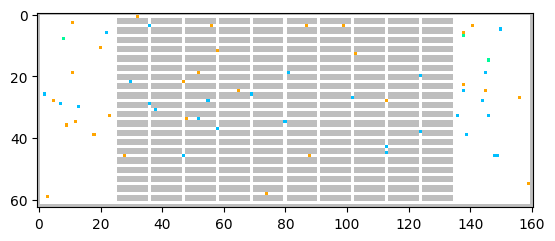

[(4, '1. no\n2. north'), (24, '1. no\n2. north'), (0, '1. no\n2. north'), (1, '1. no\n2. north'), (28, '1. no\n2. east'), (25, '1. no\n2. north'), (20, '1. no\n2. north'), (22, '1. no\n2. west'), (5, '1. no\n2. east'), (31, '1. no\n2. east'), (13, '1. no\n2. north'), (11, '1. no\n2. west'), (15, '1. no\n2. west'), (18, '1. no\n2. west'), (30, '1. no\n2. north'), (26, '1. dead end at (80, 27)\n2. south'), (19, '1. no\n2. north'), (27, '1. no\n2. east'), (21, '1. dead end at (139, 24)\n2. west'), (17, '1. dead end at (102, 35)\n2. north'), (10, '1. dead end at (136, 29)\n2. west'), (12, '1. no\n2. north'), (9, '1. no\n2. south')]


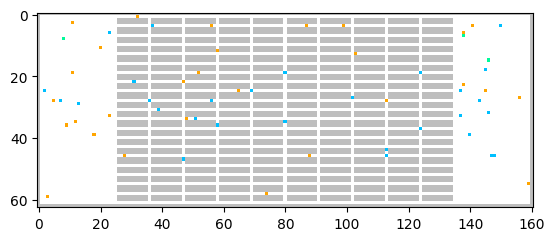

[(5, '1. no\n2. east'), (9, '1. no\n2. south'), (0, '1. no\n2. north'), (18, '1. no\n2. west'), (24, '1. no\n2. north'), (30, '1. no\n2. north'), (19, '1. no\n2. north'), (25, '1. no\n2. north'), (15, '1. no\n2. west'), (10, '1. no\n2. west'), (23, '1. no\n2. north'), (12, '1. no\n2. west'), (20, '1. no\n2. north'), (11, '1. no\n2. west'), (13, '1. no\n2. north'), (28, '1. no\n2. east'), (27, '1. no\n2. east'), (1, '1. no\n2. north'), (22, '1. no\n2. west'), (17, '1. dead end at (102, 35)\n2. north'), (26, '1. dead end at (80, 27)\n2. south'), (4, '1. no\n2. north'), (31, '1. no\n2. east'), (6, '1. [37, 31] 좌표가 3번 반복되어 dead end입니다.\n2. 나의 남쪽이 막혀있으므로, 서쪽으로 이동합니다.'), (21, '1. 좌표 [139, 24]가 3번 반복되었으므로, dead end at (139, 24)\n2. 현재 위치에서 서쪽으로 가야하며, y축 우선 원칙에 따라 가능한 방향 중에서 남쪽으로 이동합니다.')]
Error parsing dead end coordinates


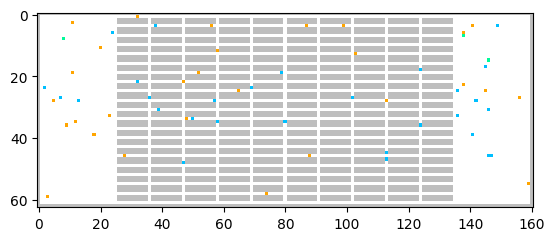

[(15, '1. no \n2. west'), (0, '1. no\n2. north'), (27, '1. no\n2. east'), (4, '1. no\n2. north'), (20, '1. no\n2. north'), (28, '1. no\n2. east'), (1, '1. no\n2. north'), (30, '1. no\n2. north'), (31, '1. no\n2. east'), (19, '1. no\n2. north'), (23, '1. no\n2. north'), (18, '1. no\n2. west'), (11, '1. no\n2. west'), (12, '1. no\n2. west'), (9, '1. no\n2. south'), (5, '1. no\n2. east'), (22, '1. no\n2. west'), (25, '1. no\n2. north'), (6, '1. dead end at (39, 31)\n2. west'), (13, '1. no\n2. north'), (26, '1. dead end at (80, 27)\n2. south'), (21, '1. no\n2. west'), (17, '1. dead end at (102, 35)\n2. north'), (10, '1. [136, 29]는 3번 등장하므로 이 좌표는 dead end입니다.\n2. 제가 서쪽으로 이동해야 하지만 y축 이동이 우선적으로 추천되기 때문에, 남쪽으로 이동하겠습니다.')]
Error parsing dead end coordinates


KeyboardInterrupt: 

: 

In [10]:
all_step_lists = simulate_all_tests(tests[0:4], 512)
print(all_step_lists)